<a href="https://colab.research.google.com/github/21-10-4/zxing/blob/master/02intermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1、CNN

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
# 可忽略
img, label = train_dataset[0]
print(img.shape)

torch.Size([1, 28, 28])


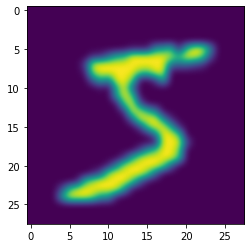

In [ ]:
# 可忽略
import matplotlib.pyplot as plt
plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")
transforms.ToPILImage()(img).show() # Alternatively

In [ ]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),# batch normalization:使一个batch的feature map满足均值为0，方差为1的分布
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)# 分类器前的处理
        out = self.fc(out)
        return out

In [ ]:
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/5], Step [100/600], Loss: 0.2061
Epoch [1/5], Step [200/600], Loss: 0.0848
Epoch [1/5], Step [300/600], Loss: 0.0766
Epoch [1/5], Step [400/600], Loss: 0.0549
Epoch [1/5], Step [500/600], Loss: 0.0787
Epoch [1/5], Step [600/600], Loss: 0.0387
Epoch [2/5], Step [100/600], Loss: 0.0351
Epoch [2/5], Step [200/600], Loss: 0.1294
Epoch [2/5], Step [300/600], Loss: 0.0208
Epoch [2/5], Step [400/600], Loss: 0.0463
Epoch [2/5], Step [500/600], Loss: 0.0119
Epoch [2/5], Step [600/600], Loss: 0.0766
Epoch [3/5], Step [100/600], Loss: 0.1463
Epoch [3/5], Step [200/600], Loss: 0.0254
Epoch [3/5], Step [300/600], Loss: 0.0087
Epoch [3/5], Step [400/600], Loss: 0.0147
Epoch [3/5], Step [500/600], Loss: 0.0087
Epoch [3/5], Step [600/600], Loss: 0.0606
Epoch [4/5], Step [100/600], Loss: 0.0234
Epoch [4/5], Step [200/600], Loss: 0.0181
Epoch [4/5], Step [300/600], Loss: 0.0349
Epoch [4/5], Step [400/600], Loss: 0.0229
Epoch [4/5], Step [500/600], Loss: 0.0059
Epoch [4/5], Step [600/600], Loss:

# 2、RNN

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Epoch [1/2], Step [100/600], Loss: 0.6829
Epoch [1/2], Step [200/600], Loss: 0.3405
Epoch [1/2], Step [300/600], Loss: 0.1877
Epoch [1/2], Step [400/600], Loss: 0.1180
Epoch [1/2], Step [500/600], Loss: 0.1537
Epoch [1/2], Step [600/600], Loss: 0.1342
Epoch [2/2], Step [100/600], Loss: 0.1108
Epoch [2/2], Step [200/600], Loss: 0.1295
Epoch [2/2], Step [300/600], Loss: 0.0990
Epoch [2/2], Step [400/600], Loss: 0.1648
Epoch [2/2], Step [500/600], Loss: 0.0231
Epoch [2/2], Step [600/600], Loss: 0.0467
Test Accuracy of the model on the 10000 test images: 97.23 %
